# RFM ANALYSIS ON CUSTOMER TRANSACTION

## ASSIGNMENT MENTORING 7
   ### BY AYA ANISA DWINIDASARI - 970038

## TASK INFORMATION
**A simple yet powerful marketing technique is an analysis utilizing recency (how recent was the customer's last purchase), frequency (how often did the customer make a purchase in a given period) and monetary (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns.**

**We are asked to segment the customer by the RFM Analysis.**

# IMPORT LIBRARY

In [182]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install sklearn

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

# Data Exploration

Import the data

In [3]:
df = pd.read_csv(r'C:\Users\970038\Downloads\DataScience-Mentoring7-master\DataScience-Mentoring7-master\transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


## Data cleaning
Check the data shape & type 

In [4]:
df.shape

(125000, 3)

In [5]:
df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

The transaction date still in OBJECT TYPE. We will change it into date time

**CHECK MISSING VALUE**

In [6]:
df.isnull().mean().sort_values(ascending=False)

customer_id     0.0
trans_date      0.0
trans_amount    0.0
dtype: float64

There are no missing value.

### Change the trans_date type to date time

In [7]:
df['trans_date']=pd.to_datetime(df['trans_date'])

ParserError: day is out of range for month: 29-Feb-17

**WE FOUND ERROR IN CHANGING TO DATE TIME TYPE : ParserError: day is out of range for month: 29-Feb-17**

**There invalid date 29 Feb due to max data is 28 Feb, so we change the 29 Feb to 28 Feb so it wouldn't out of date range**

In [8]:
df['trans_date'] = df['trans_date'].replace(['29-Feb-17'],'28-Feb-17')

**Lets retry the process of changing to date time type**

In [9]:
df['trans_date']=pd.to_datetime(df['trans_date'])

In [10]:
df.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

**After we check the data type again, the trans_date collumn has already changed to DATETIME64**

# RFM ANALYSIS DATA SHAPING

## 1. RECENCY

In [11]:
last_date=df['trans_date'].max()
last_date

Timestamp('2020-03-16 00:00:00')

### To make rencecy analysis first we should make new collumns variable of days range between each transaction date & today date (static value)

**We make variable today to show updated ongoing timestamp**

In [12]:
today = pd.to_datetime("now")

In [13]:
today

Timestamp('2021-08-28 05:38:33.365852')

**Generate time difference between their last transaction and today**

In [14]:
df['days_difference'] = (today-df['trans_date']).astype('timedelta64[D]')
df.head()

,customer_id,trans_date,trans_amount,days_difference
0,CS5295,2018-02-11,35,1294.0
1,CS4768,2020-03-15,39,531.0
2,CS2122,2018-02-26,52,1279.0
3,CS1217,2016-11-16,99,1746.0
4,CS1850,2018-11-20,78,1012.0


**The smallest days difference shows the the last (newest) transaction from the each customer, so we can short it to shows the recency based on the minimun days differences**

In [15]:
recency = df[['customer_id','days_difference']].groupby('customer_id').min().reset_index()
recency.head()

,customer_id,days_difference
0,CS1112,592.0
1,CS1113,566.0
2,CS1114,563.0
3,CS1115,541.0
4,CS1116,734.0


In [17]:
recency.rename(columns={'days_difference':'recency'}, inplace=True)
recency.head()

,customer_id,recency
0,CS1112,592.0
1,CS1113,566.0
2,CS1114,563.0
3,CS1115,541.0
4,CS1116,734.0


## 2. FREQUENCY

**The frequency shows how often the customers buy products, so we need to calculate the amount of product purchased**

In [18]:
frequency=df.groupby('customer_id').agg({'trans_amount':'count'}).reset_index()
frequency.columns=['customer_id','frequency']
frequency.head()

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13


## 3. MONETARY

**Monetary can be represented by the total of transaction amount**

In [19]:
monetary=df.groupby('customer_id').agg({'trans_amount': 'sum'}).reset_index()
monetary.columns=['customer_id','monetary']
monetary.head()

,customer_id,monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857


In [20]:
RFM1 = pd.merge(recency,frequency, on='customer_id')

In [21]:
RFM = pd.merge(RFM1,monetary,on='customer_id')
RFM.head()

,customer_id,recency,frequency,monetary
0,CS1112,592.0,15,1012
1,CS1113,566.0,20,1490
2,CS1114,563.0,19,1432
3,CS1115,541.0,22,1659
4,CS1116,734.0,13,857


In [26]:
RFM.describe()

,recency,frequency,monetary
count,6889.000000,6889.000000,6889.000000
mean,611.349252,18.144869,1179.269705
std,85.545443,5.193014,465.832609
min,530.000000,4.000000,149.000000
25%,553.000000,14.000000,781.000000
50%,584.000000,18.000000,1227.000000
75%,642.000000,22.000000,1520.000000
max,1388.000000,39.000000,2933.000000


# DISTRIBUTION PLOT

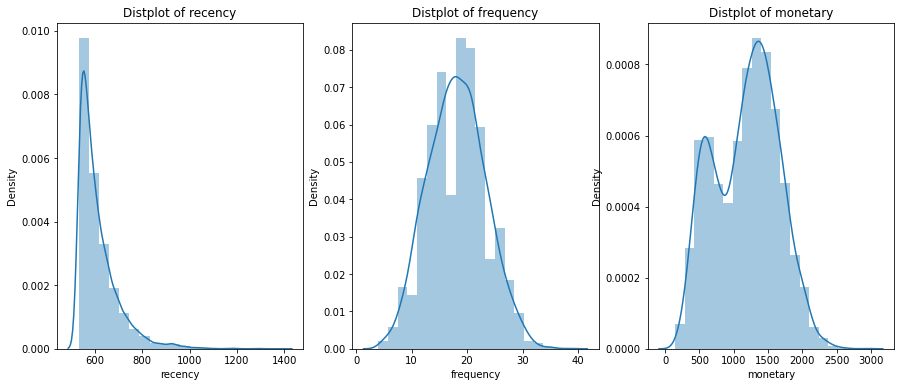

In [22]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['recency' , 'frequency' , 'monetary']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(RFM[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

## RFM SCORE

In [32]:
#createRFMscore based on the quartiles 

R_q = pd.qcut(RFM['recency'], q=4, labels = range(4,0,-1))
F_q = pd.qcut(RFM['frequency'],q=4, labels = range(1,5))
M_q = pd.qcut(RFM['monetary'],q=4,labels = range(1,5))
RFM = RFM.assign(R=R_q,F=F_q,M=M_q)

#add function to create the RFM Score & RFM segments on the table

def add_rfm_score(x) : return str(x['R']) + str(x['F']) + str(x['M'])
RFM['RFM_Segment'] = RFM.apply(add_rfm_score,axis=1 )
RFM['RFM_Score'] = RFM[['R','F','M']].sum(axis=1)

RFM.head(10)

,customer_id,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score
0,CS1112,592.0,15,1012,2,2,2,222,6
1,CS1113,566.0,20,1490,3,3,3,333,9
2,CS1114,563.0,19,1432,3,3,3,333,9
3,CS1115,541.0,22,1659,4,3,4,434,11
4,CS1116,734.0,13,857,1,1,2,112,4
5,CS1117,788.0,17,1185,1,2,2,122,5
6,CS1118,532.0,15,1011,4,2,2,422,8
7,CS1119,541.0,15,1158,4,2,2,422,8
8,CS1120,540.0,24,1677,4,4,4,444,12
9,CS1121,572.0,26,1524,3,4,4,344,11


In [37]:
RFM.groupby('RFM_Score')['recency','frequency','monetary'].mean()

,recency,frequency,monetary
RFM_Score,,,
3,766.100000,10.740000,501.283636
4,661.385036,12.662409,649.496350
5,639.184532,14.132972,818.934871
6,599.605583,14.953883,892.495146
7,611.101058,17.514689,1136.062280
8,586.869668,18.747630,1264.107820
9,595.000000,21.202649,1466.662252
10,572.497519,22.668734,1595.800248
11,559.740672,24.477612,1735.154851


**From the table above, we can see that the lowest RFM score is 3 and it's described the worst customer category. Meanwhile, the highest RFM score is 12, and it's showing the high valuable customer category (HVC)**


**In a business, we need cashflow to sustain & the recency & the frequency of the customer to repurchase, so it will create a healthy & suistanable business**

## RFM Segmentation Analysis

In a business, revenue is important as well as the suistainability of the business. So we can make an hipothesys of the customer segments based on the RFM score
- **Low value customer (LVC)** : Customers who rarely purchase & only give few revenue. They tend to purchase in low amount of money
- **Middle value customer (MVC)** : Customer who regularly purchase in middle amount of money
- **High value customer (HV)** : Customer who actively purchase with big amount of money. This customer is valuable and should be kept to continue spend their money as the company revenue

In [69]:
def segments(df):
    if df['RFM_Score'] > 9 :
        return 'High Value'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Middle Value'
    else:  
        return 'Low Value'

RFM['Segment'] = RFM.apply(segments,axis=1)

RFM.groupby('Segment').agg({'recency':'mean','frequency':'mean',
                                    'monetary':['mean','count']}).round(1)
RFM.head(10)

,customer_id,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score,Segment
0,CS1112,592.0,15,1012,2,2,2,222,6,Middle Value
1,CS1113,566.0,20,1490,3,3,3,333,9,Middle Value
2,CS1114,563.0,19,1432,3,3,3,333,9,Middle Value
3,CS1115,541.0,22,1659,4,3,4,434,11,High Value
4,CS1116,734.0,13,857,1,1,2,112,4,Low Value
5,CS1117,788.0,17,1185,1,2,2,122,5,Low Value
6,CS1118,532.0,15,1011,4,2,2,422,8,Middle Value
7,CS1119,541.0,15,1158,4,2,2,422,8,Middle Value
8,CS1120,540.0,24,1677,4,4,4,444,12,High Value
9,CS1121,572.0,26,1524,3,4,4,344,11,High Value


# CLUSTERING

### STANDARIZE VARIABLE

In [94]:
X = RFM[['recency','frequency','monetary']]
print(X.describe())

           recency    frequency     monetary
count  6889.000000  6889.000000  6889.000000
mean    611.349252    18.144869  1179.269705
std      85.545443     5.193014   465.832609
min     530.000000     4.000000   149.000000
25%     553.000000    14.000000   781.000000
50%     584.000000    18.000000  1227.000000
75%     642.000000    22.000000  1520.000000
max    1388.000000    39.000000  2933.000000


In [95]:
standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns

In [99]:
X_is = X_std[['recency' , 'frequency', 'monetary']].values

In [96]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

#Store it separately for clustering
RFM_std= scaler.transform(X)

print('mean: ', RFM_std.mean(axis=0).round(2))
print('std: ', RFM_std.std(axis=0).round(2))

mean:  [-0.  0.  0.]
std:  [1. 1. 1.]


## K MEANS CLUSTERING

In [103]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,8))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,8))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

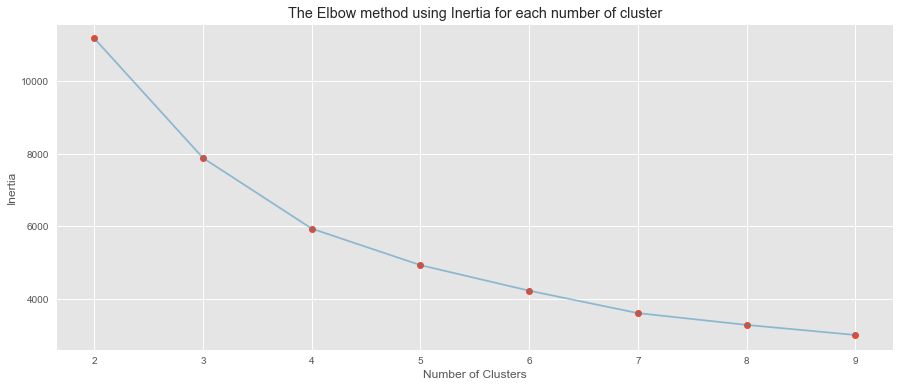

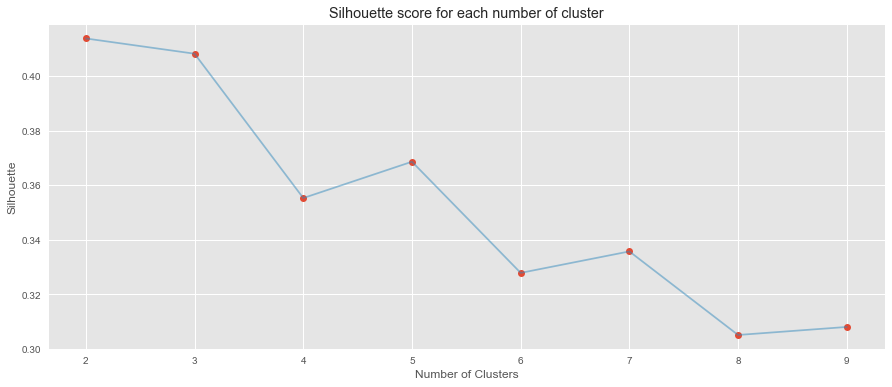

In [100]:
inertia, silhouette = k_means_inertia_silhouette(X = X_is)

**The elbow and shiloutte graph above are on different position and we do not exactly know the gradient slightness point of the elbow that indicates the number of clusters. So, let's try using yellowbrick visualizer to help distinguish the exact number of clusters. First install the packages first**

In [43]:
!pip install yellowbrick --user

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)


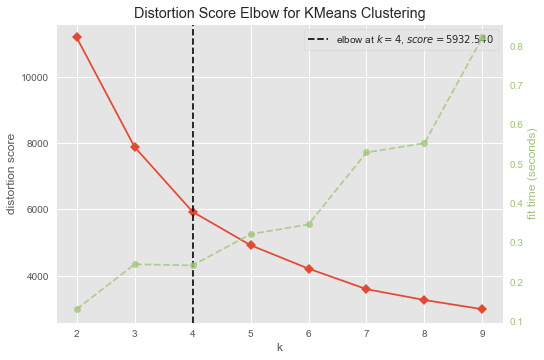

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(RFM_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

**From the graph above, it can be defined that the elbow at k=4. So, the number of cluster is 4**

In [106]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

KMeans(n_clusters=4, random_state=123)

### Visualize the Cluster Distribution

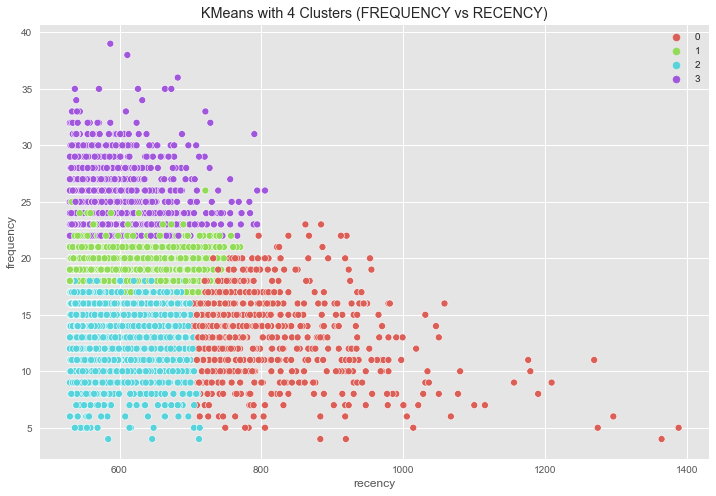

In [117]:
K_Cluster = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['recency'], X['frequency'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters (FREQUENCY vs RECENCY)'.format(k))
plt.show()

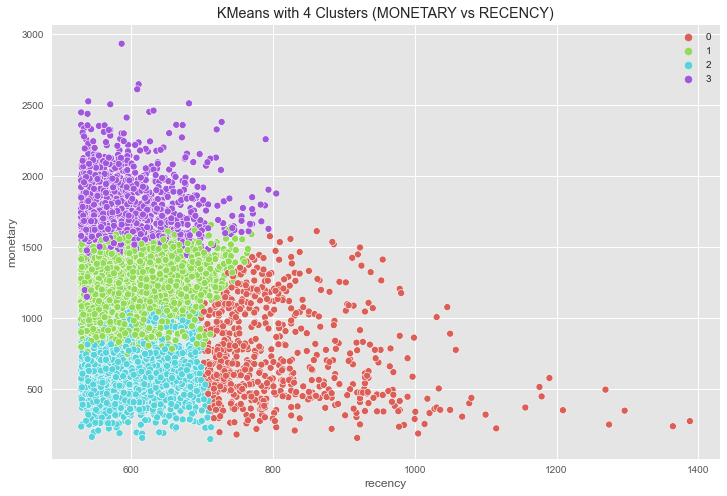

In [129]:
K_Cluster = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['recency'], X['monetary'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters (MONETARY vs RECENCY)'.format(k))
plt.show()

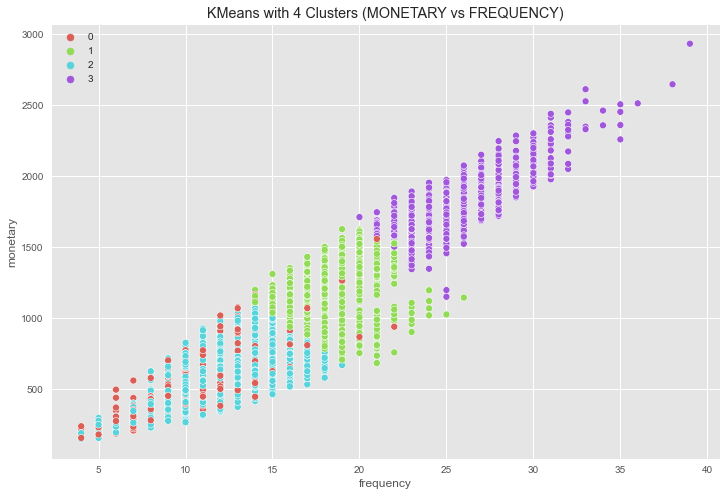

In [128]:
K_Cluster = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['frequency'], X['monetary'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters (MONETARY vs FREQUENCY)'.format(k))
plt.show()

## LIST THE CLUSTER INTO THE TABLE 

In [110]:
centroids = X[['recency','frequency','monetary']].groupby(Segment, as_index=False).mean()
centroids

,recency,frequency,monetary
0,810.691589,13.213396,754.507788
1,593.953852,18.595930,1262.949855
2,595.166667,12.746599,643.816327
3,581.563258,24.757943,1749.430965


In [118]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(RFM_std)

#Recall the label of the cluster as segment
K_Cluster = k_means.labels_



#Create new dataframe RFM_c to show the data cluster table
RFM_c = X.assign(K_Cluster = Segment)

#Grouby the aggregates mean of the RFM
RFM_c.groupby('K_Cluster').agg({'recency': 'mean','frequency': 'mean',
                                         'monetary': ['mean', 'count'],}).round(0)

recency frequency monetary      
             mean      mean     mean count
K_Cluster                                 
0           811.0      13.0    755.0   642
1           594.0      19.0   1263.0  2752
2           595.0      13.0    644.0  1764
3           582.0      25.0   1749.0  1731

**Merge the table cluster into the RFM table that has been segmented as the low,middle,and high value customer**

In [119]:
RFM_std = pd.DataFrame(RFM_std,index=X.index,columns=X.columns)
RFM_std['customer_id'] = RFM['customer_id']
RFM_std['K_Cluster'] = k_means.labels_
RFM_std['Segment'] = RFM['Segment']
RFM_std.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each
RFM_merge = pd.melt(RFM_std,id_vars=['customer_id','Segment','K_Cluster'],value_vars=['recency', 'frequency', 'monetary'],
var_name='Metric',value_name='Value')
RFM_merge

,customer_id,Segment,K_Cluster,Metric,Value
0,CS1112,Middle Value,1,recency,-0.226203
1,CS1113,Middle Value,1,recency,-0.530157
2,CS1114,Middle Value,1,recency,-0.565229
3,CS1115,High Value,3,recency,-0.822421
4,CS1116,Low Value,0,recency,1.433854
...,...,...,...,...,...
20662,CS8996,Low Value,2,monetary,-1.282248
20663,CS8997,Low Value,0,monetary,-1.365975
20664,CS8998,Low Value,2,monetary,-1.192081
20665,CS8999,Low Value,0,monetary,-1.709471


In [123]:
#add and merge the clusterung & the segmentation data
RFM['Cluster'] = 'Cluster ' + RFM_std['K_Cluster'].astype(str)
RFM.head(10)

,customer_id,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score,Segment,Cluster
0,CS1112,592.0,15,1012,2,2,2,222,6,Middle Value,Cluster 1
1,CS1113,566.0,20,1490,3,3,3,333,9,Middle Value,Cluster 1
2,CS1114,563.0,19,1432,3,3,3,333,9,Middle Value,Cluster 1
3,CS1115,541.0,22,1659,4,3,4,434,11,High Value,Cluster 3
4,CS1116,734.0,13,857,1,1,2,112,4,Low Value,Cluster 0
5,CS1117,788.0,17,1185,1,2,2,122,5,Low Value,Cluster 0
6,CS1118,532.0,15,1011,4,2,2,422,8,Middle Value,Cluster 1
7,CS1119,541.0,15,1158,4,2,2,422,8,Middle Value,Cluster 1
8,CS1120,540.0,24,1677,4,4,4,444,12,High Value,Cluster 3
9,CS1121,572.0,26,1524,3,4,4,344,11,High Value,Cluster 3


In [139]:
! pip install -U kaleido

**3D visualzation**

In [146]:
fig = px.scatter_3d(RFM, x='recency', y='frequency', z='monetary', color='Cluster',opacity = 0.8, height=800)
fig.show()

## CLUSTERING BREAKDOWN

**Create each cluster data frame**

In [154]:
Cluster0 = RFM[RFM['Cluster'] == 'Cluster 0']
Cluster1 = RFM[RFM['Cluster'] == 'Cluster 1']
Cluster2 = RFM[RFM['Cluster'] == 'Cluster 2']
Cluster3 = RFM[RFM['Cluster'] == 'Cluster 3']

**Cluster 0**

In [155]:
Cluster0[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,810.691589,13.213396,754.507788
count,642.000000,642.000000,642.000000


From the graph that we have created, cluster 0 is the customer that has low value on monetary but high recently trasaction (seldom buying) with middle frecuency.
This customer is not active customer, and they seldom do transaction although on small amount of money purchased. We can categorize this as **Inactive Customer** (*4th top category*)

**Cluster 1**

In [157]:
Cluster1[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,593.953852,18.59593,1262.949855
count,2752.000000,2752.00000,2752.000000


Cluster 1 is the customer who spend high value of money, it has low recency so the customers often do transaction (active), and medium frequency.
We can cluster this into **Potential Loyal Customer** (*2nd top category*)

**Cluster 2**

In [158]:
Cluster2[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,595.166667,12.746599,643.816327
count,1764.000000,1764.000000,1764.000000


The customer often do transaction, but in small amount of frequency, and low price. It did not give much revenue to the company. But we can keep this customer to spend more money spend. We cluster this into **Regular Customer** (*3rd top category*)

**Cluster 3**

In [163]:
Cluster3[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,581.563258,24.757943,1749.430965
count,1731.000000,1731.000000,1731.000000


The customer often do transaction with the low recency rate, and it has high frequency, and very high monetary spending.
This is high value customer so we can cluster this into **Very Loyal & Active Customer** (*1st top category*)

## Conclusion on K-means Cluster Analysis

- Cluster 0 : Inactive Customer (seldom buy, small frequency, small money spent)
- Cluster 1 : Potential Loyal Customer (often buy, medium frequency, medium money spent
- Cluster 2 : Regular Customer (often buy, low frequency, small money spent)
- Cluster 3 : Very Loyal & Active Customer (often buy, high frequency, high money spent)

In [171]:

# assign new table name cluster
cluster = k_means.labels_
# Change the existing cluster number into cluster name that we have been analysed
cluster = np.where(cluster==0, 'Inactive Customer', cluster) 
cluster = np.where(cluster=='1', 'Potential Loyal Customer', cluster) 
cluster = np.where(cluster=='2', 'Regular Customer', cluster) 
cluster =  np.where(cluster=='3', 'Very Loyal & Active Customer', cluster) 
RFM['Cluster'] = cluster
RFM.head(10)

,customer_id,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score,Segment,Cluster
0,CS1112,592.0,15,1012,2,2,2,222,6,Middle Value,Potential Loyal Customer
1,CS1113,566.0,20,1490,3,3,3,333,9,Middle Value,Potential Loyal Customer
2,CS1114,563.0,19,1432,3,3,3,333,9,Middle Value,Potential Loyal Customer
3,CS1115,541.0,22,1659,4,3,4,434,11,High Value,Very Loyal & Active Customer
4,CS1116,734.0,13,857,1,1,2,112,4,Low Value,Inactive Customer
5,CS1117,788.0,17,1185,1,2,2,122,5,Low Value,Inactive Customer
6,CS1118,532.0,15,1011,4,2,2,422,8,Middle Value,Potential Loyal Customer
7,CS1119,541.0,15,1158,4,2,2,422,8,Middle Value,Potential Loyal Customer
8,CS1120,540.0,24,1677,4,4,4,444,12,High Value,Very Loyal & Active Customer
9,CS1121,572.0,26,1524,3,4,4,344,11,High Value,Very Loyal & Active Customer


## RFM Segment with K - Means Cluster Comparison

In [172]:
Segment = RFM.copy()
Segment[['Segment','Cluster','recency','frequency','monetary']].groupby(['Cluster','Segment']).agg(['mean'])

recency  frequency     monetary
                                                 mean       mean         mean
Cluster                      Segment                                         
Inactive Customer            Low Value     810.559649  12.477193   686.080702
                             Middle Value  811.736111  19.041667  1296.222222
Potential Loyal Customer     High Value    543.008242  20.189560  1412.840659
                             Low Value     668.706250  16.537500  1113.818750
                             Middle Value  596.908887  18.483393  1249.171005
Regular Customer             Low Value     620.688688  12.220814   602.631674
                             Middle Value  552.371775  13.628225   712.874052
Very Loyal & Active Customer High Value    565.248588  24.951271  1764.186441
                             Middle Value  654.901587  23.888889  1683.101587

In [173]:
pd.DataFrame(Segment[['Segment', 'Cluster']].groupby(['Cluster', 'Segment'])['Segment'].agg('count'))

Segment
Cluster                      Segment              
Inactive Customer            Low Value         570
                             Middle Value       72
Potential Loyal Customer     High Value        364
                             Low Value         160
                             Middle Value     2228
Regular Customer             Low Value        1105
                             Middle Value      659
Very Loyal & Active Customer High Value       1416
                             Middle Value      315

### Category of customer:
- **Inactive customer** : Low Value Customer
- **Regular customer** : Low Value Customer
- **Potential Loyal Customer** : Medium Value Customer
- **Very Loyal & Active Customer** : High Value Customer

## Strategy & Recommendation Plan
- **Inactive customer** : We should engage more to get the customer awareness and try to make them being more active to purchase something, such as gamification strategy to keep them active purchasing
- **Regular customer** : We should keep this customer to keep engage and give more product recommendation based on their spending, this category customers tend to spend on cheap price, so we should keep give promos & gimmick to keep them suistain to buy, and even want to buy more expensive item (by creating special edition product to increase the loyality)
- **Potential Loyal Customer** : This customer tend to buy often with medium price, so we can create special event to engage more transaction, gamification and creating special edition & membership benefit to keep them being loyal. We also give special treatment & service to them, so they tend to be happy & purchase more
- **Very Loyal & Active Customer** : We should keep & maintain this customer, so they keep stable & sustain to do transaction. We can give reward & special membership benefit, keep good relationship & interact with them. We prioritize this customer if something trouble happen, we handle this customer first.

## RFM Snake Plot

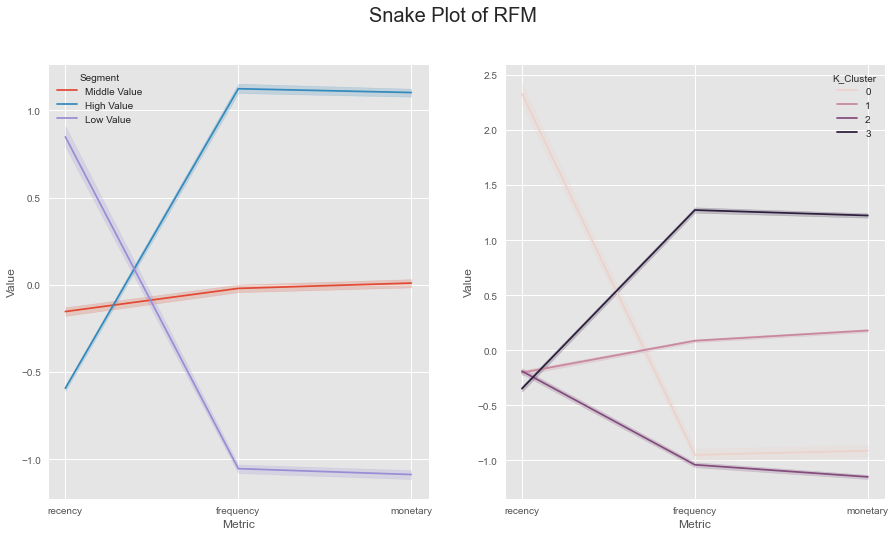

In [180]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))

# a snake plot with Segment
sns.lineplot(x = 'Metric', y = 'Value', hue = 'Segment', data = RFM_merge,ax=ax1)


# a snake plot with K-Means
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = RFM_merge,ax=ax2)

plt.suptitle("Snake Plot of RFM",fontsize=20) #make title fontsize subtitle 
plt.show()

In the snake plot we can see the cluster & segment distribution, the left table is based on Segment (LVC, MVC, HVC) and the right one is based on K means clustering that has been categorized.
The overall cluster K-means are fitted to the left snake plot, only there are addition in the middle cluster on the right plot.

## References:
Customer Segmentation by RFM Method - https://www.kaggle.com/cimbynuralam/customer-segmentation-by-rfm-method

KMeans / Data Visualize / RFM Analysis - https://www.kaggle.com/vyombhatia/kmeans-data-visualization-rfm-analysis